## Finding the correspondences between fiducial particle positions in EM and LM images

This notebook demonstrates the automatic detection of correspondences between fiducial particles in EM and LM images, followed by computation of a displacement field and warping of the LM image accordingly.

The main steps of the algorithm are:
- **1. Loading fiducial particle locations** - Fiducial particle coordinates are loaded from an .xml file for both EM (target) and LM (source) images.
- **2. Rescaling LM coordinates** - The LM fiducial coordinates are rescaled to match the coordinate system of the EM image.
- **3. Multilevel registration** - The algorithm performs a two-stage registration: first rigid, then non-rigid. It automatically identifies corresponding fiducial particles between the two modalities, assigns them matching IDs, and saves the updated information in the .xml file.
- **4. Warping the LM image** - Using the displacement field computed from the matched fiducial points, the LM image is warped to align with the EM image.

As an alternative, the updated .xml file (step 3) containing the automatically detected correspondences can be imported into the ec-CLEM software, allowing EM and LM image registration without manual annotation.

Load the necessary python libraries:

In [ ]:
import os
import open3d as o3d
import numpy as np
import pandas as pd
from pathlib import Path
import bigfish.stack as stack
import bigfish.plot as plot
from probreg import cpd
import matplotlib.pyplot as plt
from utils import xml_to_dataframe, dataframe_to_xml, dataframe_to_pointcloud
from utils import clean_correspondences, print_transformations, chamfer_distance
from utils import convert_to_pcd, save_correspondences_in2df, save_correspondences_in1df
from utils_displacement_field import expand_displacement_field, extrapolate_displacement_field, visualize_extended_field
from utils_displacement_field import calculate_displacement_vectors, plot_and_save_overlay_images, warp_image

#### 1. Loading fiducial particle locations

The locations of fiducial particles in EM (target) and LM (source) images were automatically detected using the following notebooks:

- Detect_fiducial_particles_in_EM.ipynb
- Detect_fiducial_particles_in_LM.ipynb

These detections were saved in various formats. For further processing, we load the .xml files into Pandas DataFrames. 

In [2]:
input_folder = 'E:/DATA/AI4Life_Pr26/20240805_Trial_data_fiducial_particles/240723_JB294_CLEM-AI4life_sample1/pos1/'

# Specify target and source XML files for clusters
target_xml_clust = "target_clusters.xml"
source_xml_clust = 'source_clusters.xml'

# Specify target and source XML files for regions
target_xml_regi = "target_regions.xml"
source_xml_regi = 'source_regions.xml'

#target_xml_clust = "Ground_truth_fiducials_EM_only_clusters.xml" # Ground truth fiducials
#source_xml_clust = "Ground_truth_fiducials_LM_only_clusters.xml" # Ground truth fiducials
#target_xml_regi = "Ground_truth_fiducials_EM.xml"  # Ground truth fiducial
#source_xml_regi = 'Ground_truth_fiducials_LM.xml' # Ground truth fiducial

target_path_xml_clust = Path(os.path.join(input_folder, 'output', target_xml_clust))
print(target_path_xml_clust.exists())
source_path_xml_clust = Path(os.path.join(input_folder, 'output', source_xml_clust))
print(source_path_xml_clust.exists())

target_df_clust = xml_to_dataframe(target_path_xml_clust)
#print(target_df_clust)
source_df_small_clust = xml_to_dataframe(source_path_xml_clust)   # small means it is smaller resolution than target, we need to scale it up
#print(source_df_small_clust)

# Create output folder if it does not exist
output_folder = Path(os.path.join(input_folder,"output"))
output_folder.mkdir(exist_ok=True)

True
True


#### 2. Rescaling LM coordinates

Since EM and LM images often differ in size—with LM images typically being much smaller—the coordinates of fiducial points detected in the LM image must be rescaled to match the EM image coordinate system. Without this rescaling, registration becomes difficult or inaccurate, as the two point sets would exist in incompatible spatial references.

In [3]:
def find_the_scale(EM_shape, LM_shape):
    scale_x = EM_shape[0]/LM_shape[0]
    scale_y = EM_shape[1]/LM_shape[1]
    return scale_x, scale_y

# load the EM and LM images
EM_image_path = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_bin4_EM.tif")
LM_image_path  = os.path.join(input_folder, "240726_JB295_HEK293_CLEM_LAMP1-488_Particles-555_grid4_pos1_LM.tif")

EMimage = stack.read_image(EM_image_path)
LMimage_small = stack.read_image(LM_image_path)

# Find what is the scaling rate between the 2 images
scale_y, scale_x = find_the_scale(EMimage.shape, LMimage_small.shape)

print("Scale x: ",scale_x)  # Scale_x = 22.966165413533833
print("Scale y: ",scale_y)  # Scale y:  24.873456790123456

# Resize the LM point positions
source_df_clust = xml_to_dataframe(source_path_xml_clust)
source_df_clust['pos_x'] = source_df_small_clust['pos_x']*scale_x
source_df_clust['pos_y'] = source_df_small_clust['pos_y']*scale_y

# Resize the LM image to fit the position of the resized points
LMimage = stack.resize_image(LMimage_small, EMimage.shape, method='bilinear')
#EMimage_small = stack.resize_image(EMimage, LMimage_small.shape, method='bilinear')

Scale x:  22.966165413533833
Scale y:  24.873456790123456


Plotting the point coordinates on top of the corresponding image allows us to visually verify their correct placement and ensure the coordinates were loaded and scaled properly.

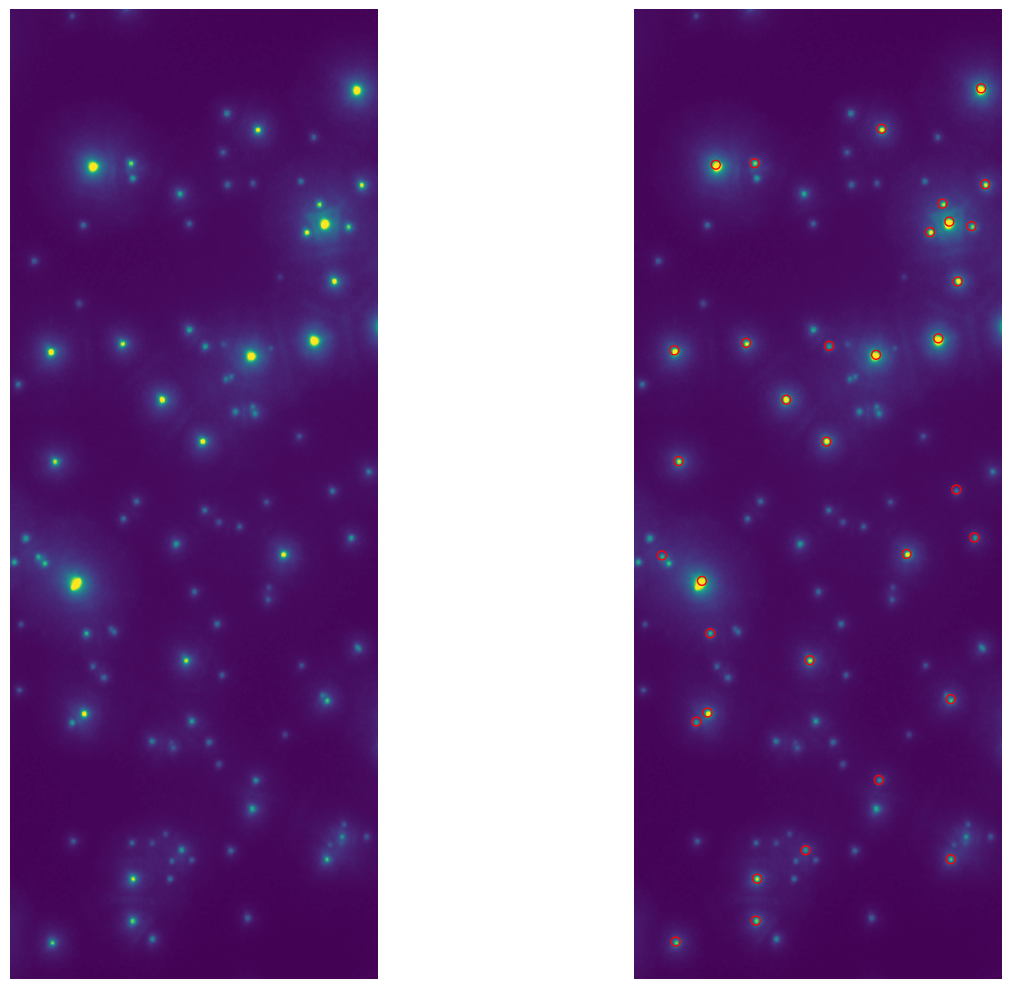

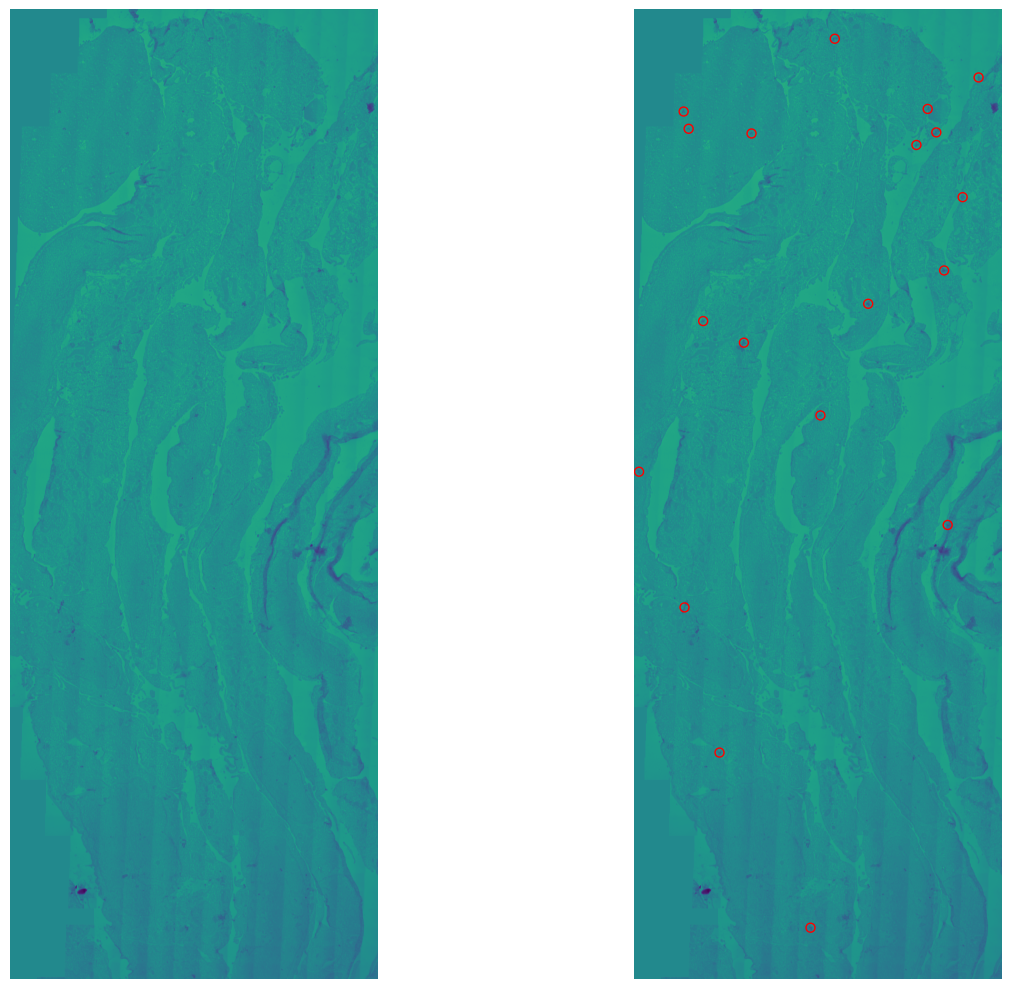

(34, 2)
(19, 2)


In [4]:
#plot.plot_detection(LMimage_small[:,:,1], source_small, contrast=True)
target_clust = target_df_clust[['pos_x', 'pos_y']].to_numpy()
source_clust = source_df_clust[['pos_x', 'pos_y']].to_numpy()

plot.plot_detection(LMimage[:,:,1], (source_clust[:, [1, 0]]), shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 
plot.plot_detection(EMimage, (target_clust[:, [1, 0]]), radius = 3*scale_y, contrast=False)

print(source_clust.shape)
print(target_clust.shape)

The fiducial points are converted from Pandas DataFrames into point clouds and saved as .ply files for further processing.

In [5]:
target_clusters = dataframe_to_pointcloud(target_df_clust, "target_clusters.ply")  #target_pcd
source_clusters = dataframe_to_pointcloud(source_df_clust, "source_clusters.ply")  #source_pcd

Loading the coordinates corresponding to the regions of fiducial particles for further analysis or processing.

In [6]:
# Load the point clouds for regions
target_path_xml_regi = Path(os.path.join(input_folder, 'output', target_xml_regi))
print(target_path_xml_regi.exists())
source_path_xml_regi = Path(os.path.join(input_folder, 'output', source_xml_regi))
print(source_path_xml_regi.exists())

target_df_regi = xml_to_dataframe(target_path_xml_regi)
print(target_df_regi)
source_df_small_regi = xml_to_dataframe(source_path_xml_regi)   # small means it is smaller resolution than target, we need to scale it up
print(source_df_small_regi)

# Resize the LM point positions
source_df_regi = xml_to_dataframe(source_path_xml_regi)
source_df_regi['pos_x'] = source_df_small_regi['pos_x']*scale_x
source_df_regi['pos_y'] = source_df_small_regi['pos_y']*scale_y

target_regions = dataframe_to_pointcloud(target_df_regi, "target_regions.ply")  #target_pcd
source_regions = dataframe_to_pointcloud(source_df_regi, "source_regions.ply")  #source_pcd

True
True
    id     name  pos_x  pos_y     color
0    0   Point1   2639    335      -154
1    1   Point2   4537    354  -3611080
2    2   Point3   3332    494    -13210
3    3   Point4   2668   1061 -16777088
4    4   Point5   5722   1137 -16744193
..  ..      ...    ...    ...       ...
83  83  Point84   3718  14807 -12582784
84  84  Point85   3718  15146    -36913
85  85  Point86   2929  15265 -16711808
86  86  Point87   5468  15563  -3355444
87  87  Point88   3042  16062        -1

[88 rows x 5 columns]
    id     name  pos_x  pos_y     color
0    0   Point1     84      0      -154
1    1   Point2     45      4  -3611080
2    2   Point3    250     54    -13210
3    3   Point4    156     69 -16777088
4    4   Point5    179     80 -16744193
..  ..      ...    ...    ...       ...
92  92  Point93    115    581 -16744193
93  93  Point94    171    607 -11776948
94  94  Point95     88    609    -65408
95  95  Point96    102    621  -8388480
96  96  Point97     30    623 -10040065

[97 ro

#### 3. Multilevel registration

The multilevel registration by Coherent Point Drift (CPD) process consists of two stages:

 - **Rigid registration** – This initial step uses a smaller number of points, specifically the coordinates of fiducial particle clusters, to align the images through translation, rotation, and scaling.

- **Non-rigid registration** – In this stage, a larger set of points is used, including the positions of individual fiducial particles located within the previously identified regions. This allows for finer, local adjustments to account for non-linear distortions between the images.

In [16]:

scale = 1000

# Convert to numpy arrays and subscale the points
source_points = np.asarray(source_clusters.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points = np.asarray(target_clusters.points)/scale          # Subscale the points, so the physical distance between them is not too large
source_points_all = np.asarray(source_clusters.points)/scale         # Subscale the points, so the physical distance between them is not too large
target_points_all = np.asarray(target_clusters.points)/scale          # Subscale the points, so the physical distance between them is not too large

# ------------------------------------------------------------------------------------------
# 1st - registration by Coherent Point Drift (CPD) - rigid
tf_param_rigid, _, _ = cpd.registration_cpd(source_points, target_points, tf_type_name='rigid', maxiter=1000, tol=1e-5)
source_points_res2 = tf_param_rigid.transform(source_points)
source_points_all_res2 = tf_param_rigid.transform(source_points_all)

#visualize_result_nparray(source_points, target_points, source_points_res2, "Rigid CPD")
print_transformations(tf_param_rigid, "Rigid CPD Transformation:")
chamfer_distance(target_points, source_points_res2, "Chamfer distance 1st - Rigid CPD")
chamfer_distance(target_points_all, source_points_all_res2, " all Chamfer distance 2nd - Nonrigid CPD")

# ------------------------------------------------------------------------------------------
# 2nd - registration by Coherent Point Drift (CPD) - nonrigid 
tf_param_nonrigid, _, _ = cpd.registration_cpd(source_points_res2, target_points, tf_type_name='nonrigid', maxiter=1000, tol=1e-5)
source_points_res3 = tf_param_nonrigid.transform(source_points_res2)

tf_param_nonrigid_all, _, _ = cpd.registration_cpd(source_points_all_res2, target_points_all, tf_type_name='nonrigid', maxiter=1000, tol=1e-5)
source_points_all_res3 = tf_param_nonrigid_all.transform(source_points_all_res2)

#visualize_result_nparray(source_points_res2, target_points, source_points_res3, "Nonrigid CPD")
print("Non-rigid CPD Transformation:")
print(tf_param_nonrigid.g)  # Displacement field
print(tf_param_nonrigid.w)  # Weight matrix

chamfer_distance(target_points, source_points_res3, "Chamfer distance 2nd - Nonrigid CPD")
chamfer_distance(target_points_all, source_points_all_res3, "all Chamfer distance 2nd - Nonrigid CPD")

Rigid CPD Transformation:
[[ 0.9910887   0.13320355  0.        ]
 [-0.13320355  0.9910887   0.        ]
 [ 0.          0.          1.        ]]
[-1.61015729 -1.04490805  0.        ]
1.1685881737980042
Chamfer distance = 0.12724492720526445 (Chamfer distance 1st - Rigid CPD) 
Chamfer distance = 0.12724492720526445 ( all Chamfer distance 2nd - Nonrigid CPD) 
Non-rigid CPD Transformation:
[[1.0000000e+00 3.3699587e-01 4.6566138e-03 ... 2.3685794e-28
  3.6966885e-31 2.3745069e-34]
 [3.3699587e-01 1.0000000e+00 1.9504435e-01 ... 2.1892793e-24
  4.8183847e-27 1.6364595e-29]
 [4.6566138e-03 1.9504435e-01 1.0000000e+00 ... 1.0933242e-21
  3.2597279e-24 8.6740322e-26]
 ...
 [2.3685794e-28 2.1892793e-24 1.0933242e-21 ... 1.0000000e+00
  8.4743202e-01 3.6801365e-01]
 [3.6966883e-31 4.8183851e-27 3.2597277e-24 ... 8.4743202e-01
  1.0000000e+00 5.2297997e-01]
 [2.3745071e-34 1.6364597e-29 8.6740322e-26 ... 3.6801365e-01
  5.2297997e-01 1.0000000e+00]]
[[-2.63516133e-015  3.60341362e-015  0.00000000

np.float64(0.01833646298682817)

Finding correspondences between the points using Point2Point algorithm - This one can be applied to full set of points. Create panda dataframe with the corresponding points having the same "id"

In [17]:
threshold = 0.02
trans_init = np.asarray([[ 1, 0, 0, 0],  # In trying to have identity matrix as initial transformation so I can instead of source point use result of non-rigid reg points and to the ICP on those
                         [ 0, 1, 0, 0],
                         [ 0, 0, 1, 0],
                         [ 0, 0, 0, 1]])

sour = convert_to_pcd(source_points_res3)
targ = convert_to_pcd(target_points)
sour_all = convert_to_pcd(source_points_all_res3)
targ_all = convert_to_pcd(target_points_all)

evaluation = o3d.pipelines.registration.evaluate_registration(sour, targ, threshold, trans_init)
evaluation_all = o3d.pipelines.registration.evaluate_registration(sour_all, targ_all, threshold, trans_init)
print("Evaluation: ", evaluation)
print("Correspondence set: ")
print(np.asarray(evaluation.correspondence_set))

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    sour, targ, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

#evaluation = o3d.pipelines.registration.evaluate_registration(sour, targ, threshold, reg_p2p.transformation)
#evaluation_all = o3d.pipelines.registration.evaluate_registration(sour_all, targ_all, threshold, reg_p2p.transformation)
#print("Evaluation: ", evaluation)
print("Correspondence set: ")
print(np.asarray(evaluation_all.correspondence_set))


correspondences = clean_correspondences(np.asarray(evaluation.correspondence_set))
correspondences_all = clean_correspondences(np.asarray(evaluation_all.correspondence_set))
print("Correspondences: ", correspondences_all)

dff2s,dff2t = save_correspondences_in2df(source_points, target_points, correspondences)

# This correspondence seems to be working in a way that corresponding point may repeat in the list. 
# same point can be corresponding to multiple points - fixed by clean_correspondences

#orig_source_df = save_correspondences_in1df(np.asarray(orig_source.points), np.asarray(orig_target.points), correspondences)
orig_source_df, orig_target_df = save_correspondences_in2df((source_points)/[scale_y,scale_x,1]*scale, 
                                                            target_points*scale, correspondences)

orig_source_all_df, orig_target_all_df = save_correspondences_in2df((source_points_all)/[scale_y,scale_x,1]*scale, 
                                                            target_points_all*scale, correspondences_all)

df = save_correspondences_in1df(source_points_all, target_points_all, correspondences_all)

dataframe_to_xml(orig_source_df, 'original_source_points_2205.xml')
dataframe_to_xml(orig_target_df, 'original_target_points_2205.xml')
dataframe_to_xml(orig_source_all_df, 'original_source_points_all_2205.xml')
dataframe_to_xml(orig_target_all_df, 'original_target_points_all_2205.xml')

Evaluation:  RegistrationResult with fitness=3.235294e-01, inlier_rmse=7.700477e-03, and correspondence_set size of 11
Access transformation to get result.
Correspondence set: 
[[10  9]
 [22 16]
 [ 8  7]
 [ 9  8]
 [20 15]
 [14 10]
 [16 13]
 [17 14]
 [31 18]
 [ 1  0]
 [ 4  1]]
Apply point-to-point ICP
RegistrationResult with fitness=3.235294e-01, inlier_rmse=7.049806e-03, and correspondence_set size of 11
Access transformation to get result.
Transformation is:
[[ 9.99999994e-01  1.10654008e-04  0.00000000e+00 -7.31994557e-04]
 [-1.10654008e-04  9.99999994e-01  0.00000000e+00 -2.64969573e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Correspondence set: 
[[ 1  0]
 [ 4  1]
 [ 8  7]
 [ 9  8]
 [10  9]
 [22 16]
 [20 15]
 [31 18]
 [14 10]
 [16 13]
 [17 14]]
Correspondences:  [[ 1  0]
 [ 4  1]
 [ 8  7]
 [ 9  8]
 [10  9]
 [14 10]
 [16 13]
 [17 14]
 [20 15]
 [22 16]
 [31 18]]


#### 4. Warping the LM image

The LM image is warped using a displacement field derived from point cloud correspondences between LM and EM images. 

Since the initial displacement field is defined only within the convex hull of the matched points, it is extrapolated to cover the entire image domain to enable full-image warping.

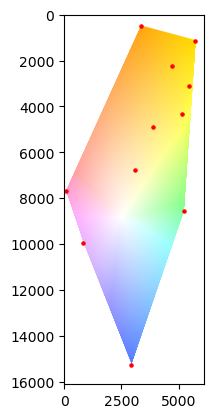

In [ ]:
source_database = orig_source_all_df
target_database = orig_target_all_df
points = np.column_stack((target_database['pos_x'], target_database['pos_y']))  #points = np.column_stack((source_database['pos_x']*scale_x, source_database['pos_y']*scale_y))

displacements = calculate_displacement_vectors(source_database, target_database, scale_x, scale_y)

points_swapped = [[x, y] for y, x in points]  # here I am swapping the x and y coordinates
displacement_field = expand_displacement_field(points_swapped, displacements, EMimage.shape)

visualize_extended_field(displacement_field, points)

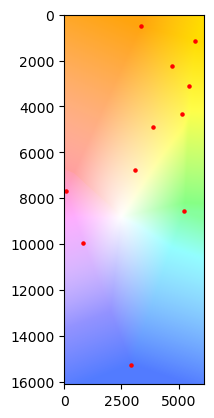

In [19]:
extrapolated_field = extrapolate_displacement_field(displacement_field)
visualize_extended_field(extrapolated_field, points)

In [20]:
warped_LMimage = warp_image(LMimage, extrapolated_field.astype(np.float16))

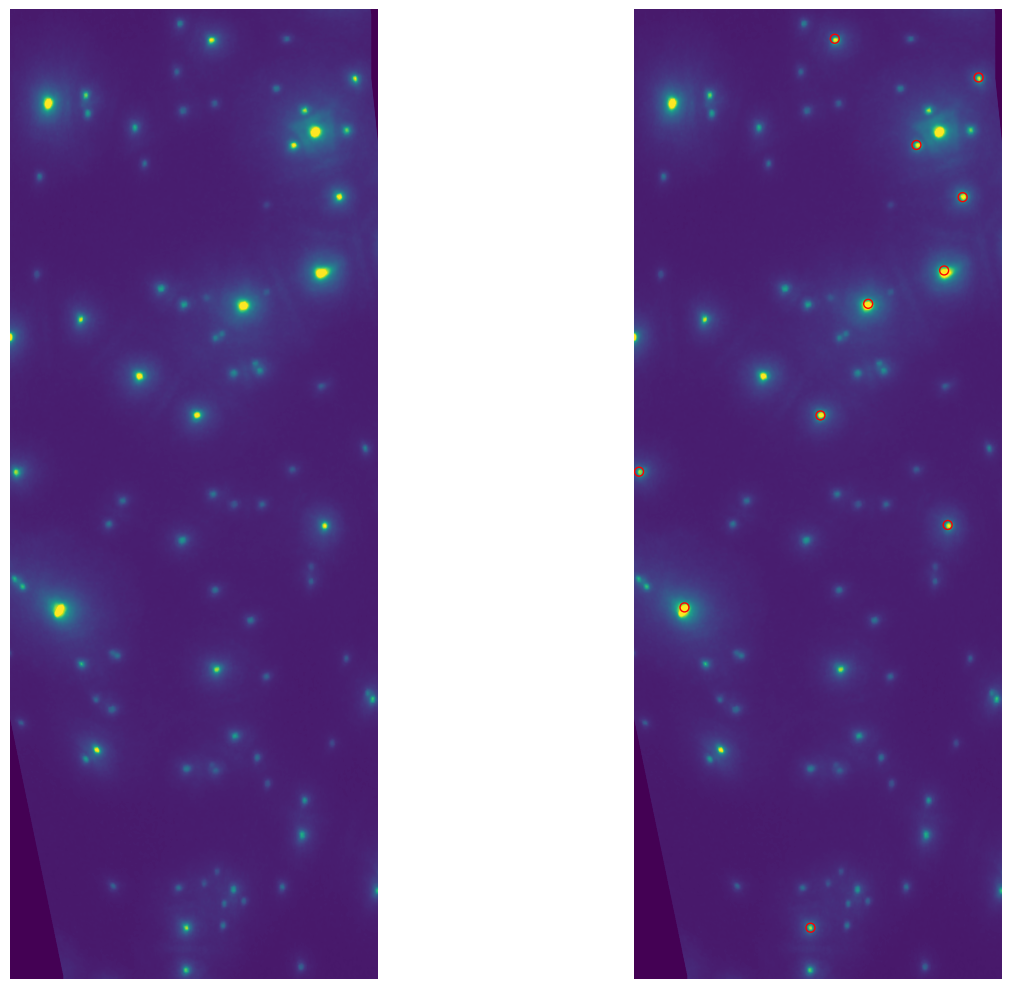

In [ ]:
def plot_image_with_points(image, dataframe, scale_y):
    points = np.column_stack((dataframe['pos_y'], dataframe['pos_x']))
    plot.plot_detection(image, points, shape="circle", radius = 3*scale_y, color = "red", linewidth = 1, fill=False, contrast=True) 
   
plot_image_with_points(warped_LMimage[:,:,1], target_database, scale_y)

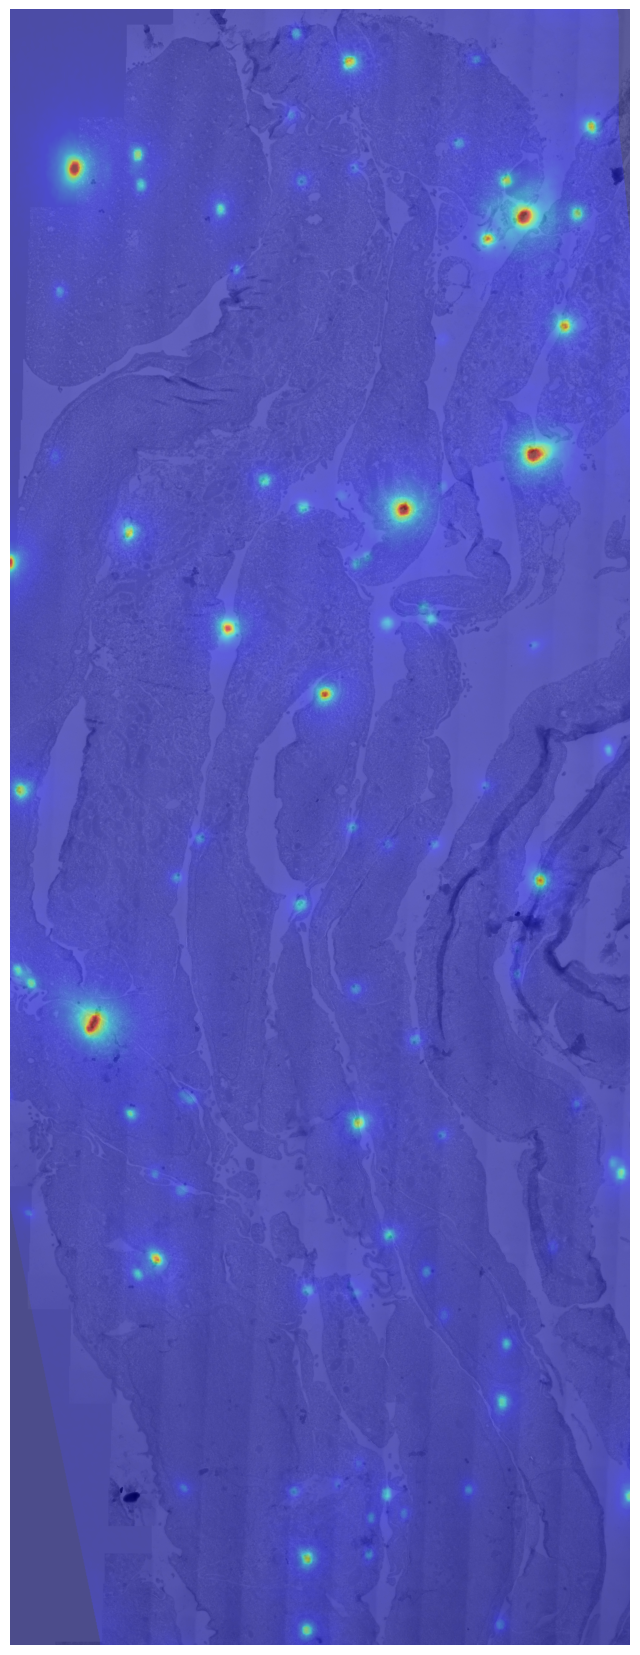

In [24]:
plot_and_save_overlay_images(EMimage, warped_LMimage[:,:,1], 'overlay_EM_LM_1.png') 

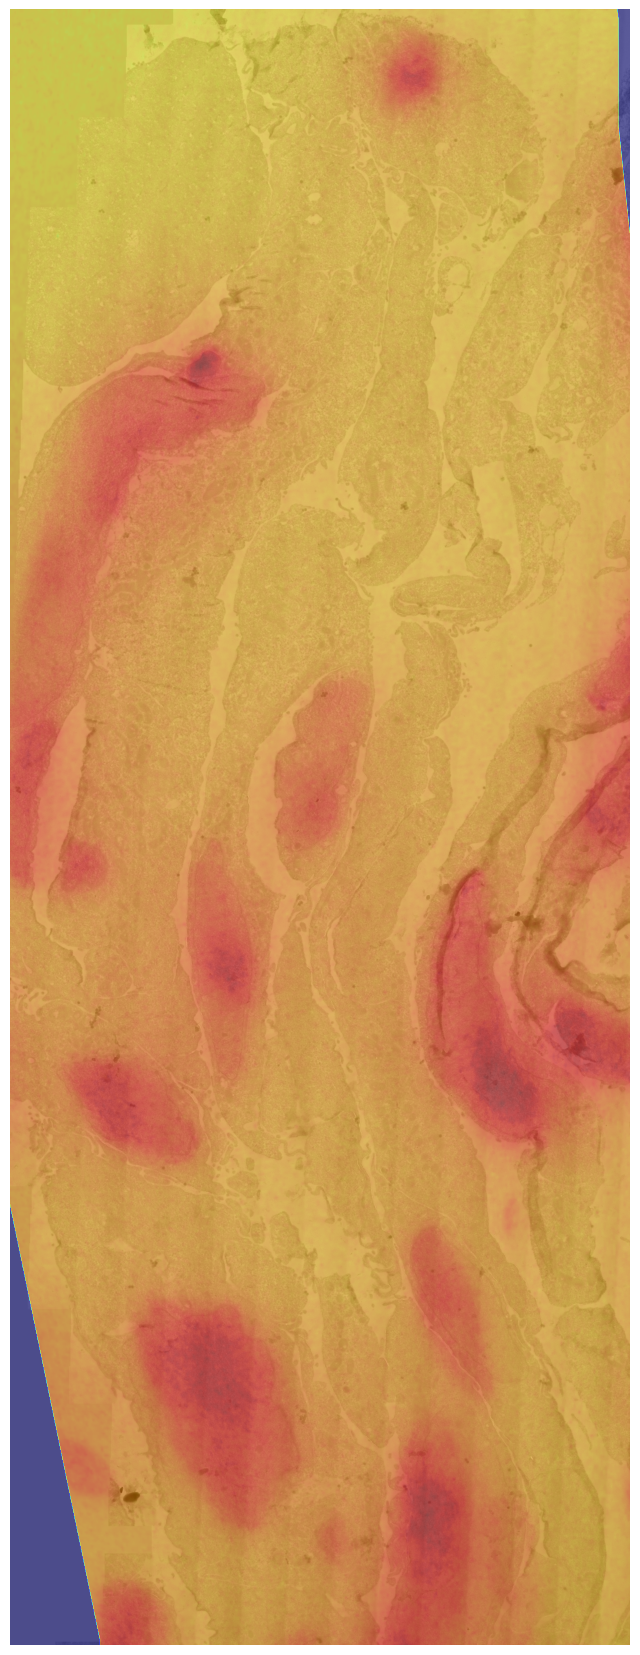

In [23]:
plot_and_save_overlay_images(EMimage, warped_LMimage[:,:,0], 'overlay_EM_LM_0.png') 